In [1]:
# Install qiskit if not already installed
!pip install qiskit
!pip install qutip
import numpy as np
import qiskit as qi
import qutip as Q
from random import random
import math
import time
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, metrics, Input
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 38.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [2]:
# Define known thripartite entanglement evolution matrices and datagenerator function
def Wstate(state):
    theta = random() * np.pi
    x1 = math.cos(theta)
    x2 = math.sin(theta)
    Ry = np.array([[x1, -x2], [x2, x1]])
    x3 = 1 / np.sqrt(2)
    S = np.array([[0., 0., 0., 0., 0., x3, 0., -x3],
                  [0., 0., 0., 0., x3, 0., -x3, 0.],
                  [0., 0., 0., 0., x3, 0., x3, 0.],
                  [0., 0., 0., 0., 0., x3, 0., x3],
                  [1., 0., 0., 0., 0., 0., 0., 0.],
                  [0., 1., 0., 0., 0., 0., 0., 0.],
                  [0., 0., 0., 1., 0., 0., 0., 0.],
                  [0., 0., 1., 0., 0., 0., 0., 0.]])
    result = np.matmul(np.matmul(S, np.kron(np.kron(Ry, np.identity(2)), np.identity(2))), state)
    return result

# GHZ circuit can be implemented in a number of ways that only make minor distinctions
def GHZ1(state):
    x = 1 / np.sqrt(2)
    S = np.matrix([[x, 0., 0., 0., x, 0., 0., 0.],
                   [0., x, 0., 0., 0., x, 0., 0.],
                   [0., 0., 0., x, 0., 0., 0., x],
                   [0., 0., x, 0., 0., 0., x, 0.],
                   [0., 0., x, 0., 0., 0., -x, 0.],
                   [0., 0., 0., x, 0., 0., 0., -x],
                   [0., x, 0., 0., 0., -x, 0., 0.],
                   [x, 0., 0., 0., -x, 0., 0., 0.]])
    result = np.matmul(S, state)
    return result

def GHZ2(state):
    x = 1 / np.sqrt(2)
    S = np.matrix([[x, 0., 0., 0., x, 0., 0., 0.],
                   [0., x, 0., 0., 0., x, 0., 0.],
                   [0., 0., x, 0., 0., 0., x, 0.],
                   [0., 0., 0., x, 0., 0., 0., x],
                   [0., 0., 0., x, 0., 0., 0., -x],
                   [0., 0., x, 0., 0., 0., -x, 0.],
                   [0., x, 0., 0., 0., -x, 0., 0.],
                   [x, 0., 0., 0., -x, 0., 0., 0.]])
    result = np.matmul(S, state)
    return result

# Generate random quantum states and calculate density matrices
def generate_density_matrices(num_samples, mixing_proportion):
    density_matrices = np.empty([num_samples, 8, 8], dtype=complex) * 0
    label = np.empty(num_samples, dtype=float)

    for i in range(0, num_samples, 5):

        S_vector1 = np.matrix(qi.quantum_info.random_statevector(2))
        S_vector2 = np.matrix(qi.quantum_info.random_statevector(2))
        S_vector3 = np.matrix(qi.quantum_info.random_statevector(2))
        S_vectort, = np.kron(np.kron(S_vector1, S_vector2), S_vector3)
        density_matrices[i, :, :] = (((np.matmul(S_vectort.getH(), S_vectort)) * (1-mixing_proportion)) +
         (np.matrix(Q.rand_dm(8, density=1, dims=[[2, 2, 2], [2, 2, 2]])) * mixing_proportion))

        label[i] = 0 #class 1

        S_vector1 = np.matrix(qi.quantum_info.random_statevector(4))
        S_vector2 = np.matrix(qi.quantum_info.random_statevector(2))
        S_vectort = np.kron(S_vector1, S_vector2)
        density_matrices[i+1, :, :] = (((np.matmul(S_vectort.getH(), S_vectort)) * (1-mixing_proportion)) +
         (np.matrix(Q.rand_dm(8, density=1, dims=[[2, 2, 2], [2, 2, 2]])) * mixing_proportion))

        label[i+1] = 1  #class 2

        S_vector1 = np.matrix(qi.quantum_info.random_statevector(4))
        S_vector2 = np.matrix(qi.quantum_info.random_statevector(2))
        AC = np.kron(S_vector1, S_vector2)
        AC[0,1], AC[0,2] = AC[0,2], AC[0,1]
        AC[0,5], AC[0,6] = AC[0,6], AC[0,5]
        S_vectort = AC
        density_matrices[i+2, :, :] = (((np.matmul(S_vectort.getH(), S_vectort)) * (1-mixing_proportion)) +
         (np.matrix(Q.rand_dm(8, density=1, dims=[[2, 2, 2], [2, 2, 2]])) * mixing_proportion))

        label[i+2] = 2  #class 3

        S_vector1 = np.matrix(qi.quantum_info.random_statevector(2))
        S_vector2 = np.matrix(qi.quantum_info.random_statevector(4))
        S_vectort = np.kron(S_vector1, S_vector2)
        density_matrices[i+3, :, :] = (((np.matmul(S_vectort.getH(), S_vectort)) * (1-mixing_proportion)) +
         (np.matrix(Q.rand_dm(8, density=1, dims=[[2, 2, 2], [2, 2, 2]])) * mixing_proportion))

        label[i+3] = 3  #class 4

        if (i % 3) == 0:
                S_vectort = Wstate(
                    np.transpose(np.kron(np.kron(np.matrix(qi.quantum_info.random_statevector(2)),
                                               np.matrix(qi.quantum_info.random_statevector(2))),
                                       np.matrix(qi.quantum_info.random_statevector(2)))))
        elif (i % 3) == 1:
            if (i % 2) == 0:
                S_vectort = GHZ1(
                     np.transpose(np.kron(np.kron(np.matrix(qi.quantum_info.random_statevector(2)),
                                                  np.matrix(qi.quantum_info.random_statevector(2))),
                                          np.matrix(qi.quantum_info.random_statevector(2)))))
            else:
                 S_vectort = GHZ2(
                        np.transpose(np.kron(np.kron(np.matrix(qi.quantum_info.random_statevector(2)),
                                                   np.matrix(qi.quantum_info.random_statevector(2))),
                                           np.matrix(qi.quantum_info.random_statevector(2)))))
        else:
                S_vectort = np.matmul(graph3, np.transpose(np.kron(np.kron(np.matrix(
                    qi.quantum_info.random_statevector(2)), np.matrix(qi.quantum_info.random_statevector(2))),
                                                                     np.matrix(qi.quantum_info.random_statevector(2)))))
        density_matrices[i+4, :, :] = (((np.matmul(S_vectort, S_vectort.getH())) * (1-mixing_proportion)) +
         (np.matrix(Q.rand_dm(8, density=1, dims=[[2, 2, 2], [2, 2, 2]])) * mixing_proportion))

        label[i+4] = 4  #class 5 including three subclasses: Wstate, GHZ, and graph state
        del S_vectort
    return density_matrices, label

In [3]:
#3 quibit graph circuite
hadamard = 1 / np.sqrt(2) * np.matrix('1, 1; 1, -1')
controlZ1 = np.matrix('1, 0, 0, 0; 0, 1, 0, 0; 0, 0, 1, 0; 0, 0, 0, -1')
graph_t3 = np.kron(np.kron(hadamard, hadamard), hadamard)
graph3 = np.matmul(np.matmul(np.kron(np.identity(2), controlZ1),
                   np.kron(controlZ1, np.identity(2))), graph_t3)
del graph_t3, controlZ1

In [4]:
# Start timer to measure dataset generation time
start = time.time()

datanum = 250000
nn = 0  # proportion of mixing density matrices (0 < nn < 1)
result = generate_density_matrices(datanum, nn)
end = time.time()
print(end - start)

344.85264229774475


In [5]:
# Labeling in one hot labeling method
one_hot_train_labels = to_categorical(result[1])
FDensity = result[0]
del result

In [7]:
# calculation of states' purity
mean = np.empty([1], dtype=complex)*0
for i in range(datanum):
  mean += qi.quantum_info.purity(FDensity[i].reshape(8,8))
print(complex(mean).real/datanum)

1.0


In [ ]:
# Modify dataset's structure
data = FDensity.reshape(datanum, 64)

# Separating real and imaginary values
vector = np.empty([datanum, 128], dtype=float)

for i in range(datanum):
    for j in range(64):
        vector[i, 2 * j] = complex(data[i, j]).real
        vector[i, 2 * j + 1] = complex(data[i, j]).imag

# Making 3D tensors
matrix = vector.reshape(datanum, 8, 16)
tensor = matrix.reshape(datanum, 8, 8, 2)

**Here we split data into imaginary and complex and turn them into 3D tensor**

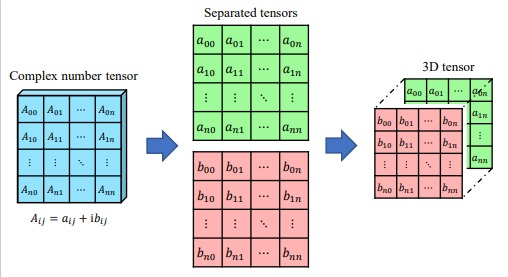

In [ ]:
# Plot t-SNE embeddings
def plot_tsne(hidden_layer_output, true_labels, label_names, alph=None):
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(hidden_layer_output)

    colors = ['r', 'g', 'b', 'gold', 'm']
    alphas = alph

    plt.figure(figsize=(10, 10))
    if alph is None:
      for i, color in enumerate(colors):
          plt.scatter(X_tsne[true_labels == i, 0], X_tsne[true_labels == i, 1], s=30,
                      c=color, marker="o", label=label_names[i], alpha=1)
    else:
      for i, color in enumerate(colors):
          plt.scatter(X_tsne[true_labels == i, 0], X_tsne[true_labels == i, 1], s=sizes(i),
                      c=color, marker="o", label=label_names[i], alpha=alphas[i])

    plt.legend()
    plt.show()

# Define a function of sizes for each of the five labels
def sizes(i):
    if (i % 5) == 0:
        result = 100
    elif (i % 5) == 1:
        result = 75
    elif (i % 5) == 2:
        result = 60
    elif (i % 5) == 3:
        result = 45
    else:
        result = 30
    return result

alphas = [1, 0.9, 0.8, 0.7, 0.6]

# Define label names
label_names = ['Sep', 'C|AB', 'B|AC', 'A|BC', 'ABC']

In [ ]:
# Define a callback for model checkpoint
callback_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='my_multi_model.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

**Here we define XpookyNet**

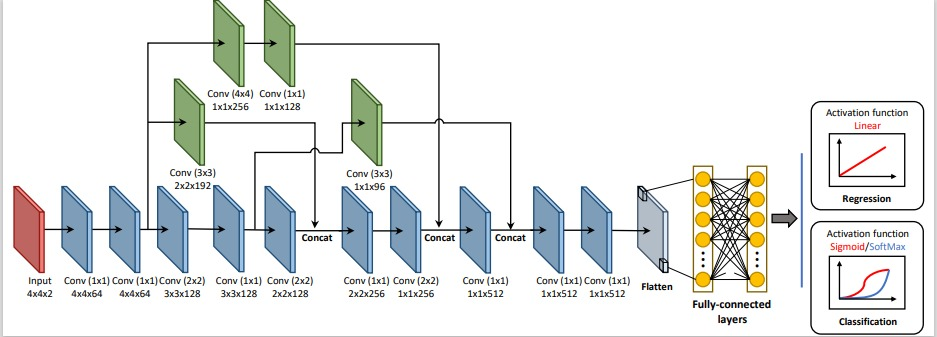

In [ ]:
# Define the XpookyNet model
def create_xpookynet_model(input_tensor):
    layer1 = layers.SeparableConv2D(64, 1)(input_tensor)
    layer1 = layers.BatchNormalization()(layer1)
    layer1 = layers.LeakyReLU()(layer1)
    layer2 = layers.SeparableConv2D(64, 1)(layer1)
    layer2 = layers.BatchNormalization()(layer2)
    layer2 = layers.LeakyReLU()(layer2)
    branch_a = layers.SeparableConv2D(256, 4)(layer2)
    branch_a = layers.BatchNormalization()(branch_a)
    branch_a = layers.LeakyReLU()(branch_a)
    branch_a = layers.SeparableConv2D(128, 1)(branch_a)
    branch_a = layers.BatchNormalization()(branch_a)
    branch_a = layers.LeakyReLU()(branch_a)
    branch_b = layers.SeparableConv2D(192, 3)(layer2)
    branch_b = layers.BatchNormalization()(branch_b)
    branch_b = layers.LeakyReLU()(branch_b)
    layer3 = layers.SeparableConv2D(128, 2)(layer2)
    layer3 = layers.BatchNormalization()(layer3)
    layer3 = layers.LeakyReLU()(layer3)
    layer4 = layers.SeparableConv2D(128, 1)(layer3)
    layer4 = layers.BatchNormalization()(layer4)
    layer4 = layers.LeakyReLU()(layer4)
    branch_c = layers.SeparableConv2D(96, 3)(layer4)
    branch_c = layers.BatchNormalization()(branch_c)
    branch_c = layers.LeakyReLU()(branch_c)
    layer5 = layers.SeparableConv2D(128, 2)(layer4)
    layer5 = layers.BatchNormalization()(layer5)
    layer5 = layers.LeakyReLU()(layer5)
    layer5 = layers.concatenate([layer5, branch_b], axis=-1)
    layer6 = layers.SeparableConv2D(256, 1)(layer5)
    layer6 = layers.BatchNormalization()(layer6)
    layer6 = layers.LeakyReLU()(layer6)
    layer7 = layers.SeparableConv2D(256, 2)(layer6)
    layer7 = layers.BatchNormalization()(layer7)
    layer7 = layers.LeakyReLU()(layer7)
    layer7 = layers.concatenate([layer7, branch_a], axis=-1)
    layer8 = layers.SeparableConv2D(512, 1)(layer7)
    layer8 = layers.BatchNormalization()(layer8)
    layer8 = layers.LeakyReLU()(layer8)
    layer8 = layers.concatenate([layer8, branch_c], axis=-1)
    layer9 = layers.SeparableConv2D(512, 1)(layer8)
    layer9 = layers.BatchNormalization()(layer9)
    layer9 = layers.LeakyReLU()(layer9)
    layer10 = layers.SeparableConv2D(512, 1)(layer9)
    layer10 = layers.BatchNormalization()(layer10)
    layer10 = layers.LeakyReLU()(layer10)
    top1 = layers.Flatten()(layer10)
    top1 = layers.Dense(512)(top1)
    top1 = layers.BatchNormalization()(top1)
    top1 = layers.LeakyReLU()(top1)
    top2 = layers.Dense(5)(top1)
    top2 = layers.BatchNormalization()(top2)
    top2 = layers.Activation('softmax')(top2)
    model = models.Model(input_tensor, top2)
    return model

In [ ]:
# Create the XpookyNet model
input_tensor = Input(shape=(8, 8, 2))
model = create_xpookynet_model(input_tensor)

In [ ]:
# Get the output of the hidden layer for a given input
hidden_layer_model = models.Model(inputs=input_tensor, outputs=model.layers[-7].output)
hidden_layer_output = hidden_layer_model.predict(tensor[(datanum - 10000):datanum, :, :, :])

true_labels = np.argmax(one_hot_train_labels[(datanum-10000):datanum, :], axis=1)

313/313 [==============================] - 3s 4ms/step


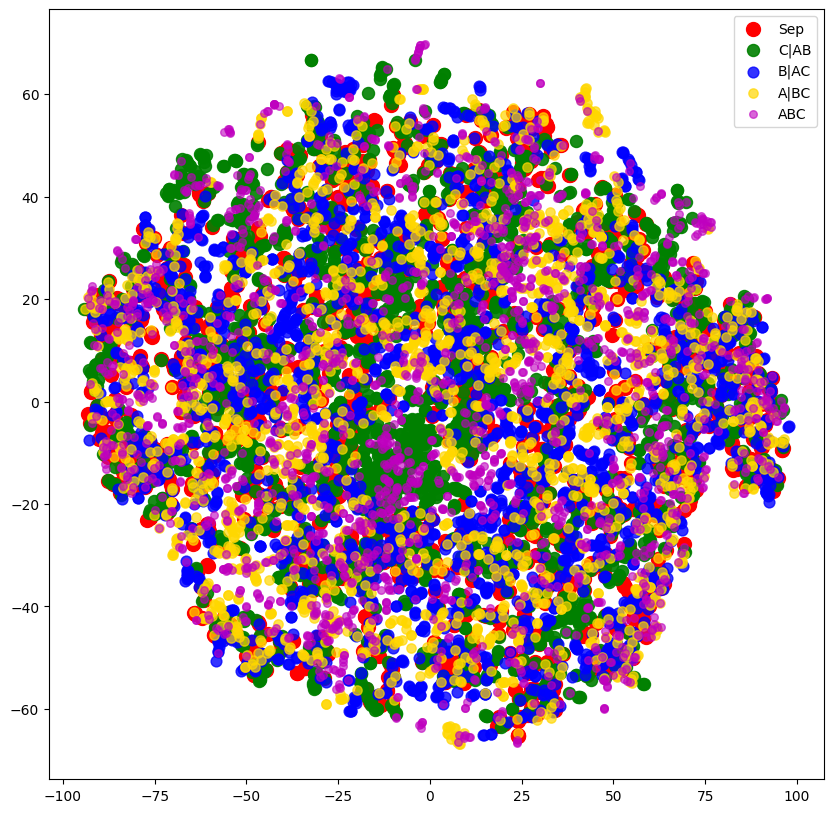

In [ ]:

# Plot t-SNE embeddings before training
plot_tsne(hidden_layer_output, true_labels, label_names, alphas)

In [ ]:
# Compile the model
model.compile(
    optimizer=optimizers.SGD(
        learning_rate=0.01, momentum=0.9,
    ),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy]
)

In [ ]:
# Train the model
history1 = model.fit(
    tensor[:datanum - 2000, :, :, :],
    one_hot_train_labels[:datanum - 2000, :],
    batch_size=125,
    epochs=1,
    callbacks=callback_list,
    validation_data=(tensor[datanum - 2000:datanum - 1000, :, :, :],
                     one_hot_train_labels[datanum - 2000:datanum - 1000, :]),
)

1983/1984 [============================>.] - ETA: 0s - loss: 0.2074 - categorical_accuracy: 0.9358

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1984/1984 [==============================] - 56s 23ms/step - loss: 0.2073 - categorical_accuracy: 0.9358 - val_loss: 0.0638 - val_categorical_accuracy: 0.9840


313/313 [==============================] - 1s 3ms/step


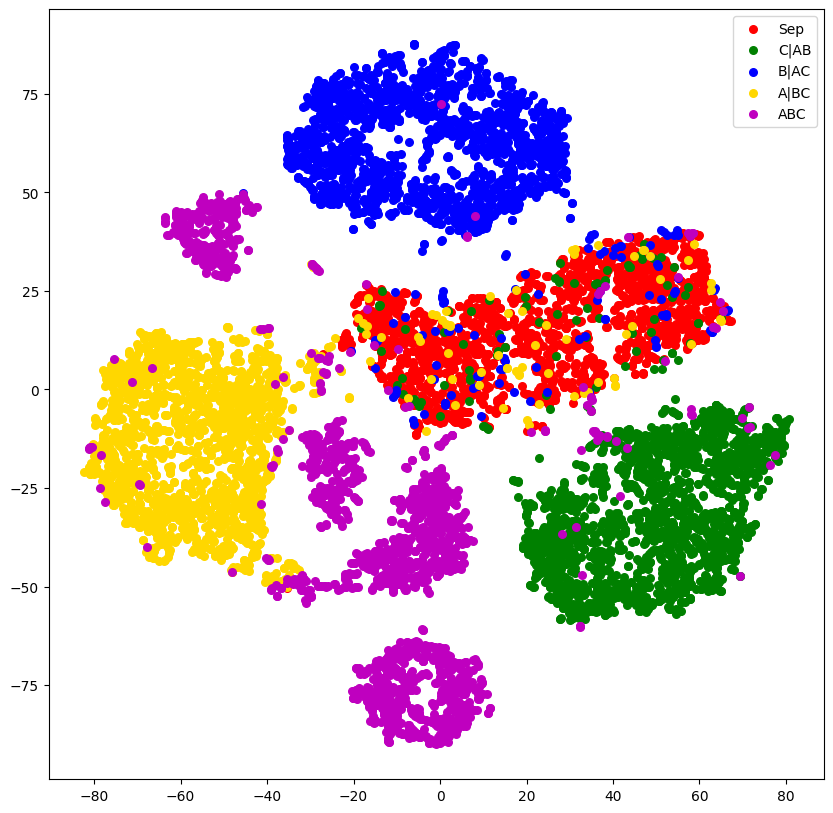

In [ ]:
# Plot t-SNE embeddings after 1 epoch
hidden_layer_output = hidden_layer_model.predict(tensor[(datanum - 10000):datanum, :, :, :])
plot_tsne(hidden_layer_output, true_labels, label_names)

In [ ]:
# Resume training
history2 = model.fit(
    tensor[:datanum - 20000, :, :, :],
    one_hot_train_labels[:datanum - 20000, :],
    batch_size=125,
    epochs=7,
    callbacks=callback_list,
    validation_data=(tensor[datanum - 20000:datanum - 10000, :, :, :],
                     one_hot_train_labels[datanum - 20000:datanum - 10000, :]),
)

Epoch 1/7
1840/1840 [==============================] - ETA: 0s - loss: 0.0535 - categorical_accuracy: 0.9864

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1840/1840 [==============================] - 44s 24ms/step - loss: 0.0535 - categorical_accuracy: 0.9864 - val_loss: 0.0293 - val_categorical_accuracy: 0.9924
Epoch 2/7
1840/1840 [==============================] - 44s 24ms/step - loss: 0.0417 - categorical_accuracy: 0.9895 - val_loss: 0.0338 - val_categorical_accuracy: 0.9908
Epoch 3/7
1840/1840 [==============================] - 44s 24ms/step - loss: 0.0348 - categorical_accuracy: 0.9912 - val_loss: 0.0271 - val_categorical_accuracy: 0.9929
Epoch 4/7
1840/1840 [==============================] - 44s 24ms/step - loss: 0.0301 - categorical_accuracy: 0.9924 - val_loss: 0.0179 - val_categorical_accuracy: 0.9954
Epoch 5/7
1840/1840 [==============================] - 43s 24ms/step - loss: 0.0262 - categorical_accuracy: 0.9934 - val_loss: 0.0347 - val_categorical_accuracy: 0.9910
Epoch 6/7
1840/1840 [==============================] - 44s 24ms/step - loss: 0.0245 - categorical_accuracy: 0.9937 - val_loss: 0.0197 - val_categorical_accuracy: 0.9

In [ ]:
# First manual reduction in learning late
model.compile(
    optimizer = optimizers.SGD(
        learning_rate = 0.001, momentum = 0.9,
    ),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy]
)

history3 = model.fit(
    tensor[:datanum-20000, :, :, :],
    one_hot_train_labels[:datanum-20000, :],
    batch_size = 125,
    epochs = 4,
    callbacks = callback_list,
    validation_data = (tensor[datanum-20000:datanum-10000, :, :, :], one_hot_train_labels[datanum-20000:datanum-10000, :]),
)

Epoch 1/4
1840/1840 [==============================] - 50s 24ms/step - loss: 0.0117 - categorical_accuracy: 0.9972 - val_loss: 0.0084 - val_categorical_accuracy: 0.9977
Epoch 2/4
1840/1840 [==============================] - 43s 24ms/step - loss: 0.0094 - categorical_accuracy: 0.9978 - val_loss: 0.0107 - val_categorical_accuracy: 0.9975
Epoch 3/4
1840/1840 [==============================] - 44s 24ms/step - loss: 0.0091 - categorical_accuracy: 0.9980 - val_loss: 0.0073 - val_categorical_accuracy: 0.9978
Epoch 4/4
1840/1840 [==============================] - 44s 24ms/step - loss: 0.0079 - categorical_accuracy: 0.9982 - val_loss: 0.0062 - val_categorical_accuracy: 0.9983


In [ ]:
# Second manual reduction in learning late
model.compile(
    optimizer = optimizers.SGD(
        learning_rate = 0.0001, momentum = 0.9,
    ),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy]
)

history4 = model.fit(
    tensor[:datanum-20000, :, :, :],
    one_hot_train_labels[:datanum-20000, :],
    batch_size = 125,
    epochs = 2,
    callbacks = callback_list,
    validation_data = (tensor[datanum-20000:datanum-10000, :, :, :], one_hot_train_labels[datanum-20000:datanum-10000, :]),
)

Epoch 1/2
1840/1840 [==============================] - 50s 24ms/step - loss: 0.0070 - categorical_accuracy: 0.9985 - val_loss: 0.0061 - val_categorical_accuracy: 0.9983
Epoch 2/2
1840/1840 [==============================] - 44s 24ms/step - loss: 0.0068 - categorical_accuracy: 0.9985 - val_loss: 0.0059 - val_categorical_accuracy: 0.9984


313/313 [==============================] - 1s 3ms/step


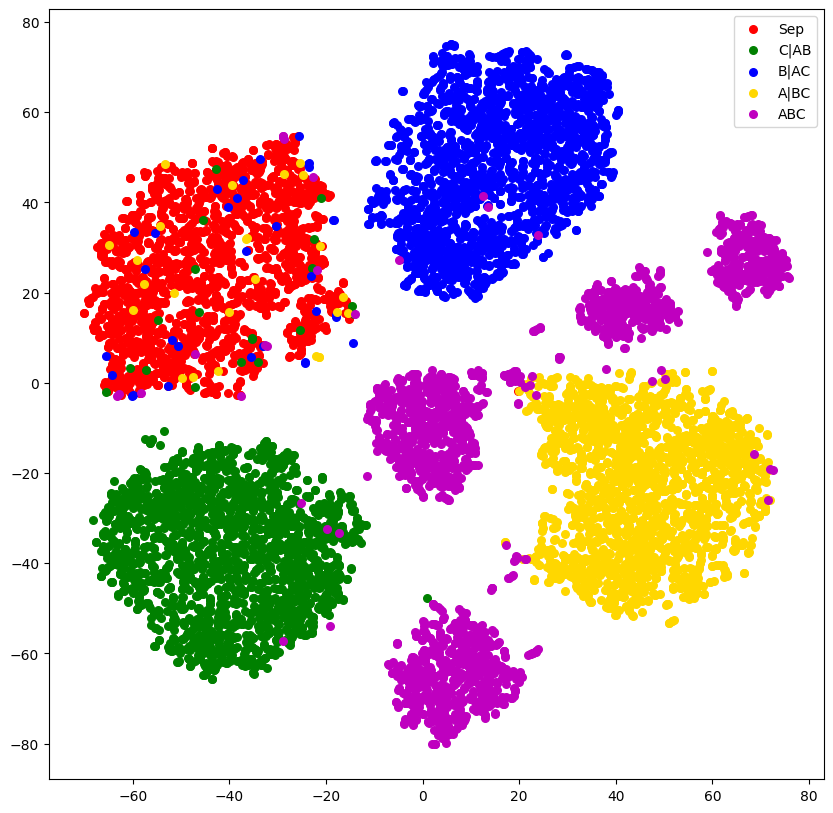

In [ ]:
# Plot t-SNE embeddings after final training
hidden_layer_output = hidden_layer_model.predict(tensor[(datanum - 10000):datanum, :, :, :])
plot_tsne(hidden_layer_output, true_labels, label_names)

In [ ]:
# Evaluate the model
my_model = tf.keras.models.load_model("my_multi_model.h5")
my_model.evaluate(tensor[datanum - 10000:datanum, :, :, :], one_hot_train_labels[datanum - 10000:datanum, :])

313/313 [==============================] - 2s 5ms/step - loss: 0.0087 - categorical_accuracy: 0.9979


[0.008690381422638893, 0.9979000091552734]

**If we repeat this, assigning the number of states getting mixed (defined as nn) 7 and 20, all these images can be obtained.**

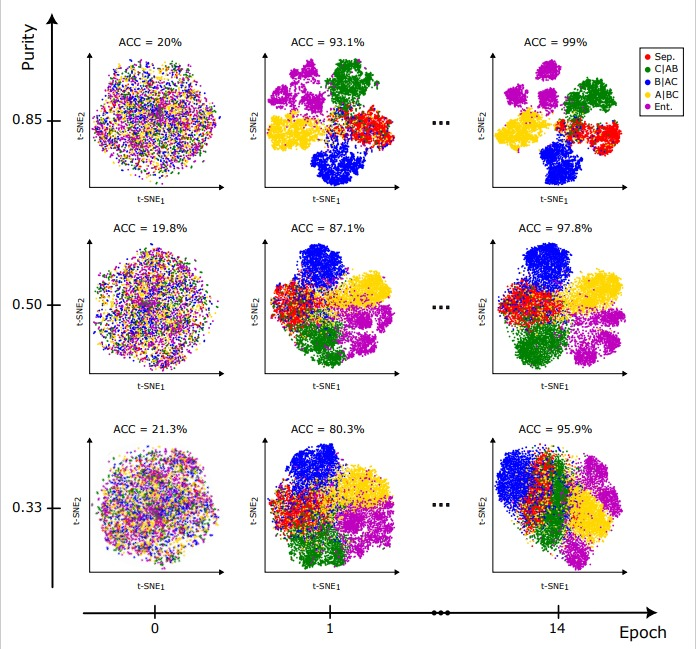

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Assuming you have the necessary data for seq_predictions and one_hot_train_labels
seq_predictions1 = my_model.predict(tensor[240000:250000, :, :, :])
seq_predictions2 = seq_predictions1.reshape(50000)
seq_predictions = np.where(seq_predictions2 < 0.5, 0, 1)
seq_predictions = np.array(seq_predictions)
seq_predictions.resize(10000, 5)

313/313 [==============================] - 1s 3ms/step


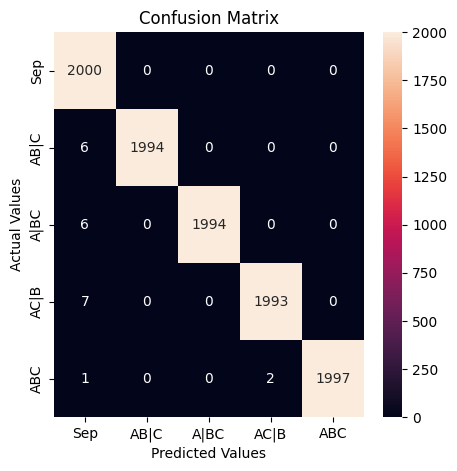

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(one_hot_train_labels[240000:250000, :].argmax(axis=1), seq_predictions.argmax(axis=1))

# Plot the confusion matrix
cm_df = pd.DataFrame(cm,
                     index=['Sep', 'AB|C', 'A|BC', 'AC|B', 'ABC'],
                     columns=['Sep', 'AB|C', 'A|BC', 'AC|B', 'ABC'])

plt.figure(figsize=(5, 5))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()